In [9]:
# Experiment 1 KD with a larger model as student

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

In [4]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  


In [5]:
# Set up the datasets
x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [6]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()
    
    model.add(layers.Dense(8192, activation='relu'))
    #model.add(layers.Dense(4096, activation='relu'))
    
    model.add(layers.Dense(1024, activation='relu'))
        
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [20]:
# Construct/load models

teacher_model = tf.keras.models.load_model('MlpTeacherModel/MlpTeacherModel')

# Perform the 10 fold cross validation
number_of_folds = 10

skf = KFold(n_splits=number_of_folds)

In [36]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse', 'mae', 'mape'],
        student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10        
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=['mse', 'mae', 'mape'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/100
443/443 [==============================] - 2s 3ms/step - mse: 749.7000 - mae: 5.6107 - mape: 379.3147 - student_loss: 5.5905 - distillation_loss: 745.5761 - val_mse: 1.2350 - val_mae: 0.8874 - val_mape: 73.9313 - val_student_loss: 1.1328
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 106.3353 - mae: 3.6070 - mape: 237.6811 - student_loss: 3.5957 - distillation_loss: 105.5396 - val_mse: 0.9566 - val_mae: 0.7727 - val_mape: 58.2381 - val_student_loss: 1.1128
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2279 - mae: 0.8245 - mape: 56.9793 - student_loss: 0.8245 - distillation_loss: 0.7814 - val_mse: 0.7768 - val_mae: 0.7024 - val_mape: 53.5192 - val_student_loss: 1.0124
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0617 - mae: 0.7546 - mape: 51.5010 - student_loss: 0.7568 - distillation_loss: 0.6146 - val_mse: 0.8499 - val_mae: 0.6848 - val_mape: 40.7302 - val_student_loss: 0.9502
Epo

443/443 [==============================] - 1s 2ms/step - mse: 0.4161 - mae: 0.4834 - mape: 31.2937 - student_loss: 0.4840 - distillation_loss: 0.0243 - val_mse: 0.3990 - val_mae: 0.4792 - val_mape: 31.5200 - val_student_loss: 0.5398
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4070 - mae: 0.4781 - mape: 30.8407 - student_loss: 0.4776 - distillation_loss: 0.0163 - val_mse: 0.3773 - val_mae: 0.4706 - val_mape: 31.3285 - val_student_loss: 0.5748
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4026 - mae: 0.4750 - mape: 30.6769 - student_loss: 0.4756 - distillation_loss: 0.0134 - val_mse: 0.3801 - val_mae: 0.4610 - val_mape: 28.7205 - val_student_loss: 0.5715
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4010 - mae: 0.4740 - mape: 30.5527 - student_loss: 0.4740 - distillation_loss: 0.0133 - val_mse: 0.3779 - val_mae: 0.4602 - val_mape: 28.9767 - val_student_loss: 0.5630
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.3940 - mae: 0.4672 - mape: 30.0275 - student_loss: 0.4682 - distillation_loss: 0.0118 - val_mse: 0.3734 - val_mae: 0.4739 - val_mape: 32.0120 - val_student_loss: 0.6096
Epoch 68/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4643 - mae: 0.5077 - mape: 33.0569 - student_loss: 0.5084 - distillation_loss: 0.0728 - val_mse: 0.5944 - val_mae: 0.6133 - val_mape: 44.1899 - val_student_loss: 0.6686
Epoch 69/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4336 - mae: 0.4979 - mape: 32.3441 - student_loss: 0.4989 - distillation_loss: 0.0435 - val_mse: 0.3912 - val_mae: 0.4741 - val_mape: 30.8625 - val_student_loss: 0.5726
Epoch 70/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4070 - mae: 0.4790 - mape: 30.9641 - student_loss: 0.4795 - distillation_loss: 0.0190 - val_mse: 0.3775 - val_mae: 0.4659 - val_mape: 30.1501 - val_student_loss: 0.5598
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.3882 - mae: 0.4638 - mape: 29.7494 - student_loss: 0.4634 - distillation_loss: 0.0076 - val_mse: 0.4169 - val_mae: 0.4784 - val_mape: 28.4182 - val_student_loss: 0.5392
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 6.8590 - mse: 1372.8387 - mae: 6.8590 - mape: 454.3520 - val_loss: 1.0270 - val_mse: 1.8320 - val_mae: 1.0270 - val_mape: 86.3077
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7580 - mse: 1.0262 - mae: 0.7580 - mape: 49.2583 - val_loss: 0.8292 - val_mse: 1.2042 - val_mae: 0.8292 - val_mape: 40.8342
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6214 - mse: 0.7033 - mae: 0.6214 - mape: 38.8349 - val_loss: 0.6687 - val_mse: 0.6600 - val_mae: 0.6687 - val_mape: 51.0992
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5828 - mse: 0.6100 - mae: 0.5828 - mape: 35.8960 - val_loss: 0.6119 - val_mse: 0.70

443/443 [==============================] - 1s 2ms/step - loss: 0.4865 - mse: 0.4360 - mae: 0.4865 - mape: 29.5433 - val_loss: 0.5117 - val_mse: 0.4355 - val_mae: 0.5117 - val_mape: 34.0788
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4874 - mse: 0.4367 - mae: 0.4874 - mape: 29.5649 - val_loss: 0.4823 - val_mse: 0.4089 - val_mae: 0.4823 - val_mape: 29.9440
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4839 - mse: 0.4315 - mae: 0.4839 - mape: 29.4505 - val_loss: 0.4626 - val_mse: 0.3847 - val_mae: 0.4626 - val_mape: 28.9409
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4894 - mse: 0.4375 - mae: 0.4894 - mape: 29.7703 - val_loss: 0.4601 - val_mse: 0.3806 - val_mae: 0.4601 - val_mape: 28.8598
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4820 - mse: 0.4264 - mae: 0.4820 - mape: 29.3338 - val_loss: 0.4628 - val_mse: 0.3918 - val_mae: 0.4628 - val_mape: 28.5464
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4623 - mse: 0.3990 - mae: 0.4623 - mape: 27.9140 - val_loss: 0.4646 - val_mse: 0.3736 - val_mae: 0.4646 - val_mape: 30.8620
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4663 - mse: 0.4057 - mae: 0.4663 - mape: 28.1964 - val_loss: 0.4450 - val_mse: 0.3640 - val_mae: 0.4450 - val_mape: 27.1931
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4552 - mse: 0.3924 - mae: 0.4552 - mape: 27.4240 - val_loss: 0.4539 - val_mse: 0.3656 - val_mae: 0.4539 - val_mape: 28.7283
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4680 - mse: 0.4102 - mae: 0.4680 - mape: 28.2509 - val_loss: 0.4573 - val_mse: 0.3891 - val_mae: 0.4573 - val_mape: 27.6814
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4619 - mse: 0.3999 - mae: 0.4619 - mape: 27.8675 - val_loss: 0.4871 - val_mse: 0.3947 - val_mae: 0.4871 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5241 - mae: 0.5454 - mape: 35.5345 - student_loss: 0.5453 - distillation_loss: 0.1078 - val_mse: 0.6737 - val_mae: 0.6466 - val_mape: 48.4478 - val_student_loss: 0.7697
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4685 - mae: 0.5168 - mape: 33.4564 - student_loss: 0.5185 - distillation_loss: 0.0592 - val_mse: 0.4442 - val_mae: 0.5054 - val_mape: 31.7669 - val_student_loss: 0.3259
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5019 - mae: 0.5354 - mape: 34.6398 - student_loss: 0.5361 - distillation_loss: 0.0895 - val_mse: 0.4513 - val_mae: 0.5113 - val_mape: 32.5978 - val_student_loss: 0.3420
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4677 - mae: 0.5130 - mape: 33.0389 - student_loss: 0.5157 - distillation_loss: 0.0602 - val_mse: 2.6600 - val_mae: 1.3155 - val_mape: 96.6660 - val_student_loss: 1.3530
Epoch 22/100
443

443/443 [==============================] - 1s 3ms/step - mse: 0.3912 - mae: 0.4667 - mape: 30.1251 - student_loss: 0.4662 - distillation_loss: 0.0089 - val_mse: 0.3836 - val_mae: 0.4698 - val_mape: 30.6909 - val_student_loss: 0.2923
Epoch 52/100
443/443 [==============================] - 1s 3ms/step - mse: 0.3918 - mae: 0.4677 - mape: 30.2380 - student_loss: 0.4676 - distillation_loss: 0.0120 - val_mse: 0.3723 - val_mae: 0.4572 - val_mape: 28.4585 - val_student_loss: 0.2360
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3997 - mae: 0.4727 - mape: 30.5863 - student_loss: 0.4722 - distillation_loss: 0.0165 - val_mse: 0.3932 - val_mae: 0.4857 - val_mape: 32.9822 - val_student_loss: 0.3719
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3981 - mae: 0.4721 - mape: 30.5034 - student_loss: 0.4718 - distillation_loss: 0.0128 - val_mse: 0.3776 - val_mae: 0.4583 - val_mape: 28.4837 - val_student_loss: 0.2172
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.3867 - mae: 0.4647 - mape: 29.9856 - student_loss: 0.4649 - distillation_loss: 0.0074 - val_mse: 0.3745 - val_mae: 0.4523 - val_mape: 27.3901 - val_student_loss: 0.1943
Epoch 85/100
443/443 [==============================] - 1s 3ms/step - mse: 0.3864 - mae: 0.4639 - mape: 29.9204 - student_loss: 0.4634 - distillation_loss: 0.0072 - val_mse: 0.3704 - val_mae: 0.4585 - val_mape: 29.3769 - val_student_loss: 0.2439
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3862 - mae: 0.4635 - mape: 29.8944 - student_loss: 0.4632 - distillation_loss: 0.0077 - val_mse: 0.3687 - val_mae: 0.4554 - val_mape: 28.6248 - val_student_loss: 0.2268
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3858 - mae: 0.4623 - mape: 29.7618 - student_loss: 0.4619 - distillation_loss: 0.0060 - val_mse: 0.3691 - val_mae: 0.4526 - val_mape: 27.8763 - val_student_loss: 0.2163
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5026 - mse: 0.4586 - mae: 0.5026 - mape: 30.7919 - val_loss: 0.5068 - val_mse: 0.4617 - val_mae: 0.5068 - val_mape: 32.1259
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5065 - mse: 0.4610 - mae: 0.5065 - mape: 31.1943 - val_loss: 0.5138 - val_mse: 0.4794 - val_mae: 0.5138 - val_mape: 28.8551
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5035 - mse: 0.4596 - mae: 0.5035 - mape: 30.7007 - val_loss: 0.4837 - val_mse: 0.4102 - val_mae: 0.4837 - val_mape: 29.6965
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4992 - mse: 0.4516 - mae: 0.4992 - mape: 30.5566 - val_loss: 0.4836 - val_mse: 0.4122 - val_mae: 0.4836 - val_mape: 30.3767
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4963 - mse: 0.4494 - mae: 0.4963 - mape: 30.3980 - val_loss: 0.6137 - val_mse: 0.6905 - val_mae: 0.6137 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.4718 - mse: 0.4111 - mae: 0.4718 - mape: 28.7429 - val_loss: 0.4717 - val_mse: 0.3990 - val_mae: 0.4717 - val_mape: 28.2004
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4785 - mse: 0.4223 - mae: 0.4785 - mape: 29.1683 - val_loss: 0.4561 - val_mse: 0.3737 - val_mae: 0.4561 - val_mape: 27.3750
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4801 - mse: 0.4223 - mae: 0.4801 - mape: 29.1795 - val_loss: 0.4625 - val_mse: 0.3871 - val_mae: 0.4625 - val_mape: 28.2381
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4826 - mse: 0.4292 - mae: 0.4826 - mape: 29.3646 - val_loss: 0.4663 - val_mse: 0.3826 - val_mae: 0.4663 - val_mape: 29.6196
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4719 - mse: 0.4111 - mae: 0.4719 - mape: 28.6419 - val_loss: 0.4557 - val_mse: 0.3862 - val_mae: 0.4557 - val_mape: 26.2705
Epo

443/443 [==============================] - 1s 3ms/step - mse: 1223.2318 - mae: 7.3185 - mape: 485.2617 - student_loss: 7.2925 - distillation_loss: 1217.4976 - val_mse: 1.0171 - val_mae: 0.7834 - val_mape: 49.6203 - val_student_loss: 0.7687
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 50.8677 - mae: 2.2005 - mape: 149.8476 - student_loss: 2.1928 - distillation_loss: 50.2033 - val_mse: 0.9042 - val_mae: 0.7321 - val_mape: 44.9558 - val_student_loss: 0.7066
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3142 - mae: 0.8456 - mape: 58.2173 - student_loss: 0.8455 - distillation_loss: 0.8553 - val_mse: 0.7483 - val_mae: 0.6912 - val_mape: 50.4088 - val_student_loss: 0.5015
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 3.5894 - mae: 1.1599 - mape: 76.5360 - student_loss: 1.1590 - distillation_loss: 3.1310 - val_mse: 0.9640 - val_mae: 0.7430 - val_mape: 40.7076 - val_student_loss: 0.5991
Epoch 5/100
443/443 [=

443/443 [==============================] - 1s 3ms/step - mse: 0.4099 - mae: 0.4797 - mape: 30.9416 - student_loss: 0.4802 - distillation_loss: 0.0225 - val_mse: 0.4964 - val_mae: 0.5348 - val_mape: 34.9011 - val_student_loss: 0.4438
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4161 - mae: 0.4853 - mape: 31.3243 - student_loss: 0.4856 - distillation_loss: 0.0271 - val_mse: 0.8424 - val_mae: 0.7295 - val_mape: 53.0008 - val_student_loss: 0.5405
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4454 - mae: 0.5004 - mape: 32.2351 - student_loss: 0.5007 - distillation_loss: 0.0483 - val_mse: 0.4601 - val_mae: 0.5065 - val_mape: 32.6417 - val_student_loss: 0.4826
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4438 - mae: 0.5024 - mape: 32.0235 - student_loss: 0.5022 - distillation_loss: 0.0446 - val_mse: 0.4296 - val_mae: 0.5051 - val_mape: 34.0508 - val_student_loss: 0.4562
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.3903 - mae: 0.4662 - mape: 29.9424 - student_loss: 0.4665 - distillation_loss: 0.0118 - val_mse: 0.3820 - val_mae: 0.4570 - val_mape: 29.1831 - val_student_loss: 0.4440
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3846 - mae: 0.4628 - mape: 29.7481 - student_loss: 0.4620 - distillation_loss: 0.0072 - val_mse: 0.3803 - val_mae: 0.4562 - val_mape: 29.0214 - val_student_loss: 0.4274
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4006 - mae: 0.4736 - mape: 30.4472 - student_loss: 0.4741 - distillation_loss: 0.0213 - val_mse: 0.3799 - val_mae: 0.4575 - val_mape: 29.5233 - val_student_loss: 0.4349
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3872 - mae: 0.4656 - mape: 29.9591 - student_loss: 0.4657 - distillation_loss: 0.0085 - val_mse: 0.3785 - val_mae: 0.4577 - val_mape: 29.4501 - val_student_loss: 0.4398
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.3923 - mae: 0.4685 - mape: 30.1999 - student_loss: 0.4698 - distillation_loss: 0.0121 - val_mse: 0.5145 - val_mae: 0.5763 - val_mape: 43.6656 - val_student_loss: 0.5501
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 9.6062 - mse: 1480.1320 - mae: 9.6062 - mape: 651.6151 - val_loss: 0.7499 - val_mse: 0.9164 - val_mae: 0.7499 - val_mape: 51.5772
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8017 - mse: 1.1516 - mae: 0.8017 - mape: 52.2709 - val_loss: 0.7937 - val_mse: 1.1093 - val_mae: 0.7937 - val_mape: 39.3690
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6402 - mse: 0.7862 - mae: 0.6402 - mape: 40.2696 - val_loss: 0.5571 - val_mse: 0.5858 - val_mae: 0.5571 - val_mape: 32.3743
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5977 - mse: 0.6540 - mae: 0.5977 - mape: 36.7904 - val_loss: 0.5233 - val_mse: 0.52

443/443 [==============================] - 1s 2ms/step - loss: 0.4853 - mse: 0.4328 - mae: 0.4853 - mape: 29.3969 - val_loss: 0.4794 - val_mse: 0.4400 - val_mae: 0.4794 - val_mape: 27.0300
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4875 - mse: 0.4308 - mae: 0.4875 - mape: 29.5627 - val_loss: 0.4771 - val_mse: 0.4012 - val_mae: 0.4771 - val_mape: 30.5795
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4849 - mse: 0.4329 - mae: 0.4849 - mape: 29.1752 - val_loss: 0.4984 - val_mse: 0.4230 - val_mae: 0.4984 - val_mape: 34.3396
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4808 - mse: 0.4236 - mae: 0.4808 - mape: 29.1196 - val_loss: 0.4922 - val_mse: 0.4582 - val_mae: 0.4922 - val_mape: 27.0637
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4840 - mse: 0.4307 - mae: 0.4840 - mape: 29.2706 - val_loss: 0.4751 - val_mse: 0.4314 - val_mae: 0.4751 - val_mape: 28.1006
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4669 - mse: 0.4113 - mae: 0.4669 - mape: 27.9157 - val_loss: 0.4770 - val_mse: 0.4009 - val_mae: 0.4770 - val_mape: 30.0752
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4612 - mse: 0.4006 - mae: 0.4612 - mape: 27.6915 - val_loss: 0.4495 - val_mse: 0.3762 - val_mae: 0.4495 - val_mape: 27.6574
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4589 - mse: 0.3952 - mae: 0.4589 - mape: 27.5848 - val_loss: 0.4582 - val_mse: 0.3825 - val_mae: 0.4582 - val_mape: 28.2769
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4583 - mse: 0.3955 - mae: 0.4583 - mape: 27.6106 - val_loss: 0.4457 - val_mse: 0.3698 - val_mae: 0.4457 - val_mape: 27.7981
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4580 - mse: 0.3932 - mae: 0.4580 - mape: 27.4523 - val_loss: 0.5280 - val_mse: 0.5450 - val_mae: 0.5280 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8839 - mae: 0.6127 - mape: 40.2406 - student_loss: 0.6132 - distillation_loss: 0.4816 - val_mse: 0.4656 - val_mae: 0.5207 - val_mape: 36.1200 - val_student_loss: 0.3485
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4430 - mae: 0.5030 - mape: 32.5146 - student_loss: 0.5021 - distillation_loss: 0.0403 - val_mse: 0.4507 - val_mae: 0.5085 - val_mape: 34.7378 - val_student_loss: 0.3666
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5767 - mae: 0.5631 - mape: 37.0020 - student_loss: 0.5625 - distillation_loss: 0.1635 - val_mse: 0.4897 - val_mae: 0.5451 - val_mape: 38.5023 - val_student_loss: 0.4293
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4707 - mae: 0.5182 - mape: 33.7355 - student_loss: 0.5183 - distillation_loss: 0.0634 - val_mse: 0.7022 - val_mae: 0.6183 - val_mape: 34.3276 - val_student_loss: 0.2426
Epoch 22/100
443

443/443 [==============================] - 1s 3ms/step - mse: 0.4166 - mae: 0.4872 - mape: 31.2489 - student_loss: 0.4879 - distillation_loss: 0.0316 - val_mse: 0.4219 - val_mae: 0.4875 - val_mape: 32.6409 - val_student_loss: 0.4024
Epoch 52/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4058 - mae: 0.4807 - mape: 30.9978 - student_loss: 0.4802 - distillation_loss: 0.0198 - val_mse: 0.4223 - val_mae: 0.4896 - val_mape: 33.3280 - val_student_loss: 0.3620
Epoch 53/100
443/443 [==============================] - 1s 3ms/step - mse: 0.3978 - mae: 0.4738 - mape: 30.5251 - student_loss: 0.4735 - distillation_loss: 0.0126 - val_mse: 0.4136 - val_mae: 0.4743 - val_mape: 30.5448 - val_student_loss: 0.3271
Epoch 54/100
443/443 [==============================] - 1s 3ms/step - mse: 0.3939 - mae: 0.4706 - mape: 30.2033 - student_loss: 0.4705 - distillation_loss: 0.0120 - val_mse: 0.4145 - val_mae: 0.4819 - val_mape: 32.5267 - val_student_loss: 0.3716
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.3816 - mae: 0.4608 - mape: 29.4577 - student_loss: 0.4602 - distillation_loss: 0.0056 - val_mse: 0.4022 - val_mae: 0.4714 - val_mape: 31.6075 - val_student_loss: 0.3346
Epoch 85/100
443/443 [==============================] - 1s 3ms/step - mse: 0.3844 - mae: 0.4636 - mape: 29.6588 - student_loss: 0.4640 - distillation_loss: 0.0097 - val_mse: 0.4197 - val_mae: 0.4974 - val_mape: 34.9462 - val_student_loss: 0.4753
Epoch 86/100
443/443 [==============================] - 1s 3ms/step - mse: 0.3969 - mae: 0.4705 - mape: 30.2617 - student_loss: 0.4701 - distillation_loss: 0.0172 - val_mse: 0.4017 - val_mae: 0.4732 - val_mape: 31.5869 - val_student_loss: 0.3369
Epoch 87/100
443/443 [==============================] - 1s 3ms/step - mse: 0.3807 - mae: 0.4605 - mape: 29.4477 - student_loss: 0.4605 - distillation_loss: 0.0058 - val_mse: 0.4140 - val_mae: 0.4891 - val_mape: 34.5206 - val_student_loss: 0.4372
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4994 - mse: 0.4526 - mae: 0.4994 - mape: 30.3778 - val_loss: 0.4993 - val_mse: 0.4513 - val_mae: 0.4993 - val_mape: 32.5343
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5060 - mse: 0.4653 - mae: 0.5060 - mape: 30.7098 - val_loss: 0.5215 - val_mse: 0.5130 - val_mae: 0.5215 - val_mape: 29.4846
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4983 - mse: 0.4512 - mae: 0.4983 - mape: 30.3617 - val_loss: 0.4905 - val_mse: 0.4453 - val_mae: 0.4905 - val_mape: 31.1472
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5059 - mse: 0.4604 - mae: 0.5059 - mape: 30.9791 - val_loss: 0.6146 - val_mse: 0.5946 - val_mae: 0.6146 - val_mape: 44.2887
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5012 - mse: 0.4551 - mae: 0.5012 - mape: 30.4192 - val_loss: 0.6314 - val_mse: 0.7163 - val_mae: 0.6314 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.4761 - mse: 0.4192 - mae: 0.4761 - mape: 28.7023 - val_loss: 0.4825 - val_mse: 0.4065 - val_mae: 0.4825 - val_mape: 33.1995
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4623 - mse: 0.3979 - mae: 0.4623 - mape: 27.8052 - val_loss: 0.5513 - val_mse: 0.5607 - val_mae: 0.5513 - val_mape: 29.8462
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4707 - mse: 0.4110 - mae: 0.4707 - mape: 28.4537 - val_loss: 0.4737 - val_mse: 0.4503 - val_mae: 0.4737 - val_mape: 27.3536
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4666 - mse: 0.4042 - mae: 0.4666 - mape: 28.1778 - val_loss: 0.4579 - val_mse: 0.4068 - val_mae: 0.4579 - val_mape: 28.8410
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4704 - mse: 0.4094 - mae: 0.4704 - mape: 28.3914 - val_loss: 0.4721 - val_mse: 0.4340 - val_mae: 0.4721 - val_mape: 28.6175
Epo

443/443 [==============================] - 2s 3ms/step - mse: 3145.6621 - mae: 9.1967 - mape: 619.2723 - student_loss: 9.1650 - distillation_loss: 3132.7474 - val_mse: 0.9461 - val_mae: 0.7860 - val_mape: 57.9075 - val_student_loss: 0.5134
Epoch 2/100
443/443 [==============================] - 1s 3ms/step - mse: 1.1942 - mae: 0.8421 - mape: 58.6984 - student_loss: 0.8423 - distillation_loss: 0.7499 - val_mse: 2.2047 - val_mae: 1.1205 - val_mape: 55.2662 - val_student_loss: 0.7366
Epoch 3/100
443/443 [==============================] - 1s 3ms/step - mse: 8.5505 - mae: 1.3906 - mape: 94.3953 - student_loss: 1.3942 - distillation_loss: 8.0937 - val_mse: 545.4898 - val_mae: 17.8828 - val_mape: 1216.0175 - val_student_loss: 10.2669
Epoch 4/100
443/443 [==============================] - 1s 3ms/step - mse: 21.9142 - mae: 2.1682 - mape: 143.9606 - student_loss: 2.1618 - distillation_loss: 21.4039 - val_mse: 1.0922 - val_mae: 0.7923 - val_mape: 43.1109 - val_student_loss: 0.6088
Epoch 5/100
443/

443/443 [==============================] - 1s 2ms/step - mse: 0.4254 - mae: 0.4909 - mape: 31.9530 - student_loss: 0.4909 - distillation_loss: 0.0309 - val_mse: 0.4169 - val_mae: 0.4883 - val_mape: 31.8690 - val_student_loss: 0.4384
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4403 - mae: 0.4964 - mape: 32.4218 - student_loss: 0.4962 - distillation_loss: 0.0415 - val_mse: 0.4341 - val_mae: 0.4818 - val_mape: 30.1388 - val_student_loss: 0.4334
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4211 - mae: 0.4891 - mape: 31.8171 - student_loss: 0.4893 - distillation_loss: 0.0281 - val_mse: 0.4182 - val_mae: 0.4835 - val_mape: 31.1797 - val_student_loss: 0.4015
Epoch 37/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4145 - mae: 0.4852 - mape: 31.6319 - student_loss: 0.4854 - distillation_loss: 0.0197 - val_mse: 0.4168 - val_mae: 0.4901 - val_mape: 32.6074 - val_student_loss: 0.4029
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.3912 - mae: 0.4687 - mape: 30.2278 - student_loss: 0.4681 - distillation_loss: 0.0100 - val_mse: 0.4236 - val_mae: 0.5038 - val_mape: 33.7257 - val_student_loss: 0.3821
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3936 - mae: 0.4700 - mape: 30.3018 - student_loss: 0.4705 - distillation_loss: 0.0105 - val_mse: 0.3961 - val_mae: 0.4747 - val_mape: 31.3013 - val_student_loss: 0.3654
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3909 - mae: 0.4673 - mape: 30.1003 - student_loss: 0.4675 - distillation_loss: 0.0099 - val_mse: 0.3902 - val_mae: 0.4652 - val_mape: 29.8009 - val_student_loss: 0.3846
Epoch 70/100
443/443 [==============================] - 1s 3ms/step - mse: 0.3891 - mae: 0.4657 - mape: 29.9601 - student_loss: 0.4662 - distillation_loss: 0.0076 - val_mse: 0.3994 - val_mae: 0.4619 - val_mape: 28.5602 - val_student_loss: 0.3890
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.3946 - mae: 0.4699 - mape: 30.3840 - student_loss: 0.4707 - distillation_loss: 0.0139 - val_mse: 0.4021 - val_mae: 0.4715 - val_mape: 29.8467 - val_student_loss: 0.3600
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 7.3674 - mse: 1726.2955 - mae: 7.3674 - mape: 521.5981 - val_loss: 1.6691 - val_mse: 5.1417 - val_mae: 1.6691 - val_mape: 128.4010
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8006 - mse: 1.1657 - mae: 0.8006 - mape: 51.9304 - val_loss: 0.8587 - val_mse: 1.2537 - val_mae: 0.8587 - val_mape: 64.8916
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6299 - mse: 0.7151 - mae: 0.6299 - mape: 39.5039 - val_loss: 0.5925 - val_mse: 0.6368 - val_mae: 0.5925 - val_mape: 35.8083
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5880 - mse: 0.6289 - mae: 0.5880 - mape: 36.3959 - val_loss: 0.6143 - val_mse: 0.5

443/443 [==============================] - 1s 2ms/step - loss: 0.4987 - mse: 0.4496 - mae: 0.4987 - mape: 30.5903 - val_loss: 0.4919 - val_mse: 0.4306 - val_mae: 0.4919 - val_mape: 30.0478
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4986 - mse: 0.4497 - mae: 0.4986 - mape: 30.3818 - val_loss: 0.4653 - val_mse: 0.4016 - val_mae: 0.4653 - val_mape: 27.7578
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4839 - mse: 0.4280 - mae: 0.4839 - mape: 29.4955 - val_loss: 0.4865 - val_mse: 0.4136 - val_mae: 0.4865 - val_mape: 31.0023
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4865 - mse: 0.4313 - mae: 0.4865 - mape: 29.7661 - val_loss: 0.4809 - val_mse: 0.4138 - val_mae: 0.4809 - val_mape: 30.1097
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4830 - mse: 0.4268 - mae: 0.4830 - mape: 29.2029 - val_loss: 0.5016 - val_mse: 0.4790 - val_mae: 0.5016 - val_mape: 26.9922
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4707 - mse: 0.4115 - mae: 0.4707 - mape: 28.3342 - val_loss: 0.4621 - val_mse: 0.3850 - val_mae: 0.4621 - val_mape: 28.9891
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4705 - mse: 0.4112 - mae: 0.4705 - mape: 28.4029 - val_loss: 0.4937 - val_mse: 0.4040 - val_mae: 0.4937 - val_mape: 35.2128
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4728 - mse: 0.4132 - mae: 0.4728 - mape: 28.5754 - val_loss: 0.4565 - val_mse: 0.3924 - val_mae: 0.4565 - val_mape: 27.1568
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4653 - mse: 0.4028 - mae: 0.4653 - mape: 28.1746 - val_loss: 0.4547 - val_mse: 0.3945 - val_mae: 0.4547 - val_mape: 26.1361
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4628 - mse: 0.3970 - mae: 0.4628 - mape: 27.8421 - val_loss: 0.5142 - val_mse: 0.4884 - val_mae: 0.5142 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4904 - mae: 0.5306 - mape: 34.2515 - student_loss: 0.5304 - distillation_loss: 0.0754 - val_mse: 0.4549 - val_mae: 0.4996 - val_mape: 31.5633 - val_student_loss: 0.7307
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4774 - mae: 0.5223 - mape: 33.6865 - student_loss: 0.5222 - distillation_loss: 0.0657 - val_mse: 0.4913 - val_mae: 0.5360 - val_mape: 35.6233 - val_student_loss: 0.7396
Epoch 20/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4899 - mae: 0.5286 - mape: 34.3271 - student_loss: 0.5282 - distillation_loss: 0.0769 - val_mse: 0.4771 - val_mae: 0.5071 - val_mape: 30.2559 - val_student_loss: 0.8443
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6300 - mae: 0.5903 - mape: 39.0866 - student_loss: 0.5920 - distillation_loss: 0.2089 - val_mse: 0.5103 - val_mae: 0.5076 - val_mape: 30.5275 - val_student_loss: 0.6731
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.3868 - mae: 0.4648 - mape: 29.8484 - student_loss: 0.4664 - distillation_loss: 0.0083 - val_mse: 0.3993 - val_mae: 0.4700 - val_mape: 31.0376 - val_student_loss: 0.6031
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3878 - mae: 0.4646 - mape: 29.8067 - student_loss: 0.4646 - distillation_loss: 0.0104 - val_mse: 0.3956 - val_mae: 0.4592 - val_mape: 29.3043 - val_student_loss: 0.5916
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3889 - mae: 0.4650 - mape: 29.8491 - student_loss: 0.4653 - distillation_loss: 0.0102 - val_mse: 0.3928 - val_mae: 0.4572 - val_mape: 29.1231 - val_student_loss: 0.5693
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3857 - mae: 0.4638 - mape: 29.7591 - student_loss: 0.4631 - distillation_loss: 0.0077 - val_mse: 0.4670 - val_mae: 0.5385 - val_mape: 39.4261 - val_student_loss: 0.7374
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.3777 - mae: 0.4588 - mape: 29.3754 - student_loss: 0.4584 - distillation_loss: 0.0039 - val_mse: 0.3848 - val_mae: 0.4524 - val_mape: 28.7124 - val_student_loss: 0.5524
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3865 - mae: 0.4647 - mape: 29.8233 - student_loss: 0.4638 - distillation_loss: 0.0089 - val_mse: 0.3974 - val_mae: 0.4748 - val_mape: 32.1367 - val_student_loss: 0.6501
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3857 - mae: 0.4639 - mape: 29.7392 - student_loss: 0.4640 - distillation_loss: 0.0086 - val_mse: 0.3995 - val_mae: 0.4713 - val_mape: 31.0553 - val_student_loss: 0.6201
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4081 - mae: 0.4770 - mape: 30.6644 - student_loss: 0.4790 - distillation_loss: 0.0263 - val_mse: 0.4692 - val_mae: 0.5113 - val_mape: 33.3915 - val_student_loss: 0.7028
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5203 - mse: 0.4977 - mae: 0.5203 - mape: 31.6050 - val_loss: 0.7760 - val_mse: 0.9059 - val_mae: 0.7760 - val_mape: 56.1955
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5076 - mse: 0.4656 - mae: 0.5076 - mape: 30.9234 - val_loss: 0.4815 - val_mse: 0.4216 - val_mae: 0.4815 - val_mape: 30.9695
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4968 - mse: 0.4488 - mae: 0.4968 - mape: 30.2529 - val_loss: 0.5351 - val_mse: 0.4636 - val_mae: 0.5351 - val_mape: 37.6411
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5028 - mse: 0.4583 - mae: 0.5028 - mape: 30.5594 - val_loss: 0.5636 - val_mse: 0.5151 - val_mae: 0.5636 - val_mape: 39.2630
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5007 - mse: 0.4510 - mae: 0.5007 - mape: 30.4559 - val_loss: 0.5765 - val_mse: 0.6153 - val_mae: 0.5765 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.4767 - mse: 0.4172 - mae: 0.4767 - mape: 28.8028 - val_loss: 0.4631 - val_mse: 0.4063 - val_mae: 0.4631 - val_mape: 27.7972
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4699 - mse: 0.4070 - mae: 0.4699 - mape: 28.4082 - val_loss: 0.4680 - val_mse: 0.4237 - val_mae: 0.4680 - val_mape: 27.3263
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4789 - mse: 0.4216 - mae: 0.4789 - mape: 29.0995 - val_loss: 0.4560 - val_mse: 0.3841 - val_mae: 0.4560 - val_mape: 29.3118
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4768 - mse: 0.4198 - mae: 0.4768 - mape: 28.8125 - val_loss: 0.4745 - val_mse: 0.3943 - val_mae: 0.4745 - val_mape: 32.2497
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4685 - mse: 0.4056 - mae: 0.4685 - mape: 28.3686 - val_loss: 0.4966 - val_mse: 0.4711 - val_mae: 0.4966 - val_mape: 27.2856
Epo

443/443 [==============================] - 2s 3ms/step - mse: 1329.6532 - mae: 7.6005 - mape: 498.1665 - student_loss: 7.5721 - distillation_loss: 1323.5815 - val_mse: 0.9436 - val_mae: 0.7395 - val_mape: 44.6640 - val_student_loss: 0.9534
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 2.0029 - mae: 0.9873 - mape: 68.1550 - student_loss: 0.9869 - distillation_loss: 1.5453 - val_mse: 0.8231 - val_mae: 0.7206 - val_mape: 50.2387 - val_student_loss: 0.8398
Epoch 3/100
443/443 [==============================] - 1s 3ms/step - mse: 2.0949 - mae: 1.0226 - mape: 70.2052 - student_loss: 1.0275 - distillation_loss: 1.6681 - val_mse: 31.5131 - val_mae: 4.3189 - val_mape: 253.9784 - val_student_loss: 6.2522
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 3.6352 - mae: 1.1676 - mape: 78.8710 - student_loss: 1.1849 - distillation_loss: 3.3414 - val_mse: 117.7986 - val_mae: 8.5442 - val_mape: 578.1395 - val_student_loss: 10.1167
Epoch 5/100
443/443

443/443 [==============================] - 1s 2ms/step - mse: 0.4085 - mae: 0.4807 - mape: 31.0565 - student_loss: 0.4803 - distillation_loss: 0.0256 - val_mse: 0.4234 - val_mae: 0.4907 - val_mape: 31.9933 - val_student_loss: 0.8129
Epoch 35/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4037 - mae: 0.4765 - mape: 30.8584 - student_loss: 0.4768 - distillation_loss: 0.0217 - val_mse: 0.4535 - val_mae: 0.4896 - val_mape: 28.7244 - val_student_loss: 0.9322
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4279 - mae: 0.4935 - mape: 31.7493 - student_loss: 0.4925 - distillation_loss: 0.0340 - val_mse: 0.4481 - val_mae: 0.5066 - val_mape: 33.0742 - val_student_loss: 0.7802
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4238 - mae: 0.4876 - mape: 31.4681 - student_loss: 0.4876 - distillation_loss: 0.0370 - val_mse: 0.5122 - val_mae: 0.5428 - val_mape: 35.0172 - val_student_loss: 0.8941
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.3994 - mae: 0.4748 - mape: 30.7622 - student_loss: 0.4739 - distillation_loss: 0.0184 - val_mse: 0.4263 - val_mae: 0.4829 - val_mape: 30.2109 - val_student_loss: 0.8757
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3962 - mae: 0.4725 - mape: 30.6517 - student_loss: 0.4726 - distillation_loss: 0.0165 - val_mse: 0.4524 - val_mae: 0.5199 - val_mape: 34.5404 - val_student_loss: 0.7580
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4073 - mae: 0.4745 - mape: 30.8362 - student_loss: 0.4745 - distillation_loss: 0.0223 - val_mse: 0.4199 - val_mae: 0.4764 - val_mape: 29.4710 - val_student_loss: 0.9227
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3948 - mae: 0.4705 - mape: 30.3749 - student_loss: 0.4703 - distillation_loss: 0.0176 - val_mse: 0.4398 - val_mae: 0.5058 - val_mape: 32.9929 - val_student_loss: 0.8129
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.3821 - mae: 0.4619 - mape: 29.7994 - student_loss: 0.4611 - distillation_loss: 0.0081 - val_mse: 0.4421 - val_mae: 0.5108 - val_mape: 33.3371 - val_student_loss: 0.7215
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 10.0476 - mse: 2527.9302 - mae: 10.0476 - mape: 677.1146 - val_loss: 0.6882 - val_mse: 0.7756 - val_mae: 0.6882 - val_mape: 45.4193
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7594 - mse: 0.9971 - mae: 0.7594 - mape: 49.6265 - val_loss: 0.7466 - val_mse: 0.8125 - val_mae: 0.7466 - val_mape: 57.3906
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6049 - mse: 0.6477 - mae: 0.6049 - mape: 37.8858 - val_loss: 0.5334 - val_mse: 0.5163 - val_mae: 0.5334 - val_mape: 33.2402
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5750 - mse: 0.5974 - mae: 0.5750 - mape: 35.2991 - val_loss: 0.5732 - val_mse: 0.

443/443 [==============================] - 1s 2ms/step - loss: 0.4886 - mse: 0.4361 - mae: 0.4886 - mape: 29.7684 - val_loss: 0.5087 - val_mse: 0.4602 - val_mae: 0.5087 - val_mape: 32.5666
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4839 - mse: 0.4305 - mae: 0.4839 - mape: 29.2765 - val_loss: 0.4797 - val_mse: 0.4366 - val_mae: 0.4797 - val_mape: 28.2360
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4804 - mse: 0.4244 - mae: 0.4804 - mape: 29.1395 - val_loss: 0.4889 - val_mse: 0.4461 - val_mae: 0.4889 - val_mape: 29.6727
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4850 - mse: 0.4296 - mae: 0.4850 - mape: 29.5042 - val_loss: 0.5129 - val_mse: 0.5009 - val_mae: 0.5129 - val_mape: 28.2033
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4871 - mse: 0.4293 - mae: 0.4871 - mape: 29.7983 - val_loss: 0.5132 - val_mse: 0.4553 - val_mae: 0.5132 - val_mape: 34.3510
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4767 - mse: 0.4208 - mae: 0.4767 - mape: 28.6122 - val_loss: 0.4683 - val_mse: 0.4303 - val_mae: 0.4683 - val_mape: 26.2324
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4662 - mse: 0.4070 - mae: 0.4662 - mape: 27.8414 - val_loss: 0.4708 - val_mse: 0.4304 - val_mae: 0.4708 - val_mape: 26.6208
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4666 - mse: 0.4048 - mae: 0.4666 - mape: 27.9278 - val_loss: 0.5948 - val_mse: 0.5558 - val_mae: 0.5948 - val_mape: 40.3401
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4648 - mse: 0.4042 - mae: 0.4648 - mape: 27.7855 - val_loss: 0.4868 - val_mse: 0.4754 - val_mae: 0.4868 - val_mape: 25.6090
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4691 - mse: 0.4106 - mae: 0.4691 - mape: 28.1146 - val_loss: 0.4722 - val_mse: 0.4366 - val_mae: 0.4722 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5316 - mae: 0.5472 - mape: 35.9176 - student_loss: 0.5467 - distillation_loss: 0.1178 - val_mse: 0.4313 - val_mae: 0.5105 - val_mape: 35.1810 - val_student_loss: 0.2306
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4846 - mae: 0.5261 - mape: 34.2621 - student_loss: 0.5259 - distillation_loss: 0.0729 - val_mse: 0.4266 - val_mae: 0.5036 - val_mape: 34.3117 - val_student_loss: 0.2290
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4667 - mae: 0.5136 - mape: 33.4020 - student_loss: 0.5125 - distillation_loss: 0.0548 - val_mse: 0.4733 - val_mae: 0.5120 - val_mape: 31.3628 - val_student_loss: 0.2820
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4606 - mae: 0.5120 - mape: 33.1828 - student_loss: 0.5118 - distillation_loss: 0.0501 - val_mse: 0.4283 - val_mae: 0.5141 - val_mape: 36.0899 - val_student_loss: 0.1961
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.4118 - mae: 0.4817 - mape: 31.1424 - student_loss: 0.4805 - distillation_loss: 0.0223 - val_mse: 0.4074 - val_mae: 0.4967 - val_mape: 35.7868 - val_student_loss: 0.2659
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4276 - mae: 0.4929 - mape: 31.9385 - student_loss: 0.4929 - distillation_loss: 0.0354 - val_mse: 0.3909 - val_mae: 0.4668 - val_mape: 29.4750 - val_student_loss: 0.2317
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4058 - mae: 0.4790 - mape: 30.9664 - student_loss: 0.4785 - distillation_loss: 0.0188 - val_mse: 0.3794 - val_mae: 0.4630 - val_mape: 30.2890 - val_student_loss: 0.2601
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3976 - mae: 0.4733 - mape: 30.5996 - student_loss: 0.4727 - distillation_loss: 0.0126 - val_mse: 0.3822 - val_mae: 0.4630 - val_mape: 30.6116 - val_student_loss: 0.2104
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.3888 - mae: 0.4652 - mape: 29.8148 - student_loss: 0.4665 - distillation_loss: 0.0077 - val_mse: 0.3660 - val_mae: 0.4559 - val_mape: 30.3253 - val_student_loss: 0.2030
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3990 - mae: 0.4733 - mape: 30.4382 - student_loss: 0.4739 - distillation_loss: 0.0180 - val_mse: 0.3709 - val_mae: 0.4578 - val_mape: 30.3402 - val_student_loss: 0.2057
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3932 - mae: 0.4691 - mape: 30.1823 - student_loss: 0.4692 - distillation_loss: 0.0123 - val_mse: 0.3692 - val_mae: 0.4519 - val_mape: 29.3188 - val_student_loss: 0.2181
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3873 - mae: 0.4642 - mape: 29.7450 - student_loss: 0.4651 - distillation_loss: 0.0066 - val_mse: 0.3892 - val_mae: 0.4551 - val_mape: 27.7926 - val_student_loss: 0.2089
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5083 - mse: 0.4704 - mae: 0.5083 - mape: 30.9178 - val_loss: 0.5535 - val_mse: 0.4698 - val_mae: 0.5535 - val_mape: 39.5748
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5035 - mse: 0.4574 - mae: 0.5035 - mape: 30.7175 - val_loss: 0.4751 - val_mse: 0.4019 - val_mae: 0.4751 - val_mape: 30.8835
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4983 - mse: 0.4532 - mae: 0.4983 - mape: 30.2357 - val_loss: 0.4716 - val_mse: 0.3948 - val_mae: 0.4716 - val_mape: 30.2653
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4983 - mse: 0.4504 - mae: 0.4983 - mape: 30.5000 - val_loss: 0.4884 - val_mse: 0.4009 - val_mae: 0.4884 - val_mape: 32.4157
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5065 - mse: 0.4609 - mae: 0.5065 - mape: 30.9155 - val_loss: 0.4744 - val_mse: 0.4018 - val_mae: 0.4744 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.4720 - mse: 0.4123 - mae: 0.4720 - mape: 28.4328 - val_loss: 0.4628 - val_mse: 0.4000 - val_mae: 0.4628 - val_mape: 27.3070
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4788 - mse: 0.4249 - mae: 0.4788 - mape: 29.1019 - val_loss: 0.4692 - val_mse: 0.4137 - val_mae: 0.4692 - val_mape: 28.8075
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4786 - mse: 0.4237 - mae: 0.4786 - mape: 28.9071 - val_loss: 0.4656 - val_mse: 0.3862 - val_mae: 0.4656 - val_mape: 30.7335
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4791 - mse: 0.4229 - mae: 0.4791 - mape: 29.1263 - val_loss: 0.4838 - val_mse: 0.3989 - val_mae: 0.4838 - val_mape: 32.0170
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4783 - mse: 0.4220 - mae: 0.4783 - mape: 29.1312 - val_loss: 0.4772 - val_mse: 0.3853 - val_mae: 0.4772 - val_mape: 33.2527
Epo

443/443 [==============================] - 2s 3ms/step - mse: 1264.2104 - mae: 6.2992 - mape: 425.4218 - student_loss: 6.2851 - distillation_loss: 1258.1732 - val_mse: 7.2082 - val_mae: 2.1672 - val_mape: 117.6167 - val_student_loss: 2.6228
Epoch 2/100
443/443 [==============================] - 1s 3ms/step - mse: 6.8558 - mae: 1.4007 - mape: 96.1226 - student_loss: 1.4135 - distillation_loss: 6.4753 - val_mse: 6.4329 - val_mae: 1.6606 - val_mape: 95.8555 - val_student_loss: 1.9012
Epoch 3/100
443/443 [==============================] - 1s 3ms/step - mse: 33.2422 - mae: 3.0636 - mape: 208.4273 - student_loss: 3.0540 - distillation_loss: 32.7561 - val_mse: 1.3117 - val_mae: 0.8628 - val_mape: 43.1892 - val_student_loss: 1.0001
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 4.5983 - mae: 1.1910 - mape: 80.5686 - student_loss: 1.1933 - distillation_loss: 4.1389 - val_mse: 2.0120 - val_mae: 1.0513 - val_mape: 56.6745 - val_student_loss: 1.1744
Epoch 5/100
443/443 [

443/443 [==============================] - 1s 2ms/step - mse: 0.4269 - mae: 0.4913 - mape: 31.6355 - student_loss: 0.4914 - distillation_loss: 0.0249 - val_mse: 0.4173 - val_mae: 0.4930 - val_mape: 32.7456 - val_student_loss: 0.4574
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4106 - mae: 0.4820 - mape: 31.0252 - student_loss: 0.4845 - distillation_loss: 0.0177 - val_mse: 0.3745 - val_mae: 0.4575 - val_mape: 29.5293 - val_student_loss: 0.4828
Epoch 36/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4373 - mae: 0.4974 - mape: 32.0228 - student_loss: 0.4966 - distillation_loss: 0.0350 - val_mse: 0.4245 - val_mae: 0.4961 - val_mape: 33.0971 - val_student_loss: 0.4960
Epoch 37/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4136 - mae: 0.4835 - mape: 31.2047 - student_loss: 0.4819 - distillation_loss: 0.0179 - val_mse: 0.3927 - val_mae: 0.4606 - val_mape: 29.9155 - val_student_loss: 0.4881
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.3898 - mae: 0.4670 - mape: 30.0555 - student_loss: 0.4667 - distillation_loss: 0.0068 - val_mse: 0.3626 - val_mae: 0.4499 - val_mape: 29.2614 - val_student_loss: 0.5141
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3896 - mae: 0.4663 - mape: 29.9704 - student_loss: 0.4649 - distillation_loss: 0.0062 - val_mse: 0.3628 - val_mae: 0.4442 - val_mape: 28.1494 - val_student_loss: 0.5167
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3907 - mae: 0.4670 - mape: 30.0373 - student_loss: 0.4672 - distillation_loss: 0.0084 - val_mse: 0.3760 - val_mae: 0.4622 - val_mape: 30.5305 - val_student_loss: 0.4861
Epoch 70/100
443/443 [==============================] - 1s 3ms/step - mse: 0.3927 - mae: 0.4675 - mape: 30.0911 - student_loss: 0.4673 - distillation_loss: 0.0088 - val_mse: 0.3672 - val_mae: 0.4571 - val_mape: 30.0955 - val_student_loss: 0.4998
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.3844 - mae: 0.4623 - mape: 29.7009 - student_loss: 0.4624 - distillation_loss: 0.0048 - val_mse: 0.3722 - val_mae: 0.4514 - val_mape: 29.1182 - val_student_loss: 0.5100
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 10.0398 - mse: 1838.9076 - mae: 10.0398 - mape: 661.2883 - val_loss: 0.7744 - val_mse: 0.9211 - val_mae: 0.7744 - val_mape: 62.4957
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7685 - mse: 1.0831 - mae: 0.7685 - mape: 49.7565 - val_loss: 0.5656 - val_mse: 0.9122 - val_mae: 0.5656 - val_mape: 35.6272
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6467 - mse: 0.7433 - mae: 0.6467 - mape: 40.5029 - val_loss: 0.8205 - val_mse: 1.1108 - val_mae: 0.8205 - val_mape: 62.4220
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5917 - mse: 0.6380 - mae: 0.5917 - mape: 36.4321 - val_loss: 0.5565 - val_mse: 0.

443/443 [==============================] - 1s 2ms/step - loss: 0.4855 - mse: 0.4310 - mae: 0.4855 - mape: 29.5070 - val_loss: 0.4733 - val_mse: 0.3930 - val_mae: 0.4733 - val_mape: 30.6120
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4895 - mse: 0.4366 - mae: 0.4895 - mape: 29.9065 - val_loss: 0.4570 - val_mse: 0.3671 - val_mae: 0.4570 - val_mape: 30.1544
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4913 - mse: 0.4371 - mae: 0.4913 - mape: 29.9027 - val_loss: 0.4485 - val_mse: 0.3716 - val_mae: 0.4485 - val_mape: 27.4585
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4892 - mse: 0.4362 - mae: 0.4892 - mape: 29.7211 - val_loss: 0.4510 - val_mse: 0.3982 - val_mae: 0.4510 - val_mape: 25.7695
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4910 - mse: 0.4404 - mae: 0.4910 - mape: 29.9281 - val_loss: 0.4457 - val_mse: 0.3861 - val_mae: 0.4457 - val_mape: 25.5303
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4608 - mse: 0.3994 - mae: 0.4608 - mape: 27.7456 - val_loss: 0.5218 - val_mse: 0.4705 - val_mae: 0.5218 - val_mape: 33.4690
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4699 - mse: 0.4114 - mae: 0.4699 - mape: 28.4697 - val_loss: 0.4295 - val_mse: 0.3690 - val_mae: 0.4295 - val_mape: 23.9113
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4635 - mse: 0.4025 - mae: 0.4635 - mape: 28.0105 - val_loss: 0.5163 - val_mse: 0.5287 - val_mae: 0.5163 - val_mape: 25.8861
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4644 - mse: 0.4017 - mae: 0.4644 - mape: 28.2218 - val_loss: 0.4618 - val_mse: 0.3945 - val_mae: 0.4618 - val_mape: 29.4016
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4622 - mse: 0.3993 - mae: 0.4622 - mape: 27.8800 - val_loss: 0.4314 - val_mse: 0.3568 - val_mae: 0.4314 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5613 - mae: 0.5557 - mape: 36.5589 - student_loss: 0.5549 - distillation_loss: 0.1463 - val_mse: 0.4788 - val_mae: 0.5299 - val_mape: 34.0229 - val_student_loss: 0.6159
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4757 - mae: 0.5209 - mape: 33.7015 - student_loss: 0.5207 - distillation_loss: 0.0685 - val_mse: 0.5364 - val_mae: 0.5891 - val_mape: 41.0833 - val_student_loss: 0.5860
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4472 - mae: 0.5052 - mape: 32.6731 - student_loss: 0.5050 - distillation_loss: 0.0426 - val_mse: 0.4821 - val_mae: 0.5045 - val_mape: 29.0428 - val_student_loss: 0.6295
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4477 - mae: 0.5041 - mape: 32.6997 - student_loss: 0.5055 - distillation_loss: 0.0440 - val_mse: 0.4799 - val_mae: 0.5198 - val_mape: 32.0515 - val_student_loss: 0.5777
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.3932 - mae: 0.4703 - mape: 30.5058 - student_loss: 0.4698 - distillation_loss: 0.0126 - val_mse: 0.4127 - val_mae: 0.4892 - val_mape: 31.0903 - val_student_loss: 0.5541
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3909 - mae: 0.4685 - mape: 30.3138 - student_loss: 0.4688 - distillation_loss: 0.0116 - val_mse: 0.4130 - val_mae: 0.4747 - val_mape: 28.6722 - val_student_loss: 0.5457
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3880 - mae: 0.4663 - mape: 30.1545 - student_loss: 0.4666 - distillation_loss: 0.0081 - val_mse: 0.4025 - val_mae: 0.4709 - val_mape: 28.7121 - val_student_loss: 0.5727
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.3924 - mae: 0.4690 - mape: 30.3236 - student_loss: 0.4684 - distillation_loss: 0.0109 - val_mse: 0.4018 - val_mae: 0.4839 - val_mape: 31.1971 - val_student_loss: 0.5580
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.3814 - mae: 0.4611 - mape: 29.8554 - student_loss: 0.4602 - distillation_loss: 0.0056 - val_mse: 0.4019 - val_mae: 0.4756 - val_mape: 29.9153 - val_student_loss: 0.5648
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4033 - mae: 0.4698 - mape: 30.4397 - student_loss: 0.4700 - distillation_loss: 0.0247 - val_mse: 0.4479 - val_mae: 0.5342 - val_mape: 36.8312 - val_student_loss: 0.5277
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4199 - mae: 0.4898 - mape: 32.0753 - student_loss: 0.4894 - distillation_loss: 0.0382 - val_mse: 0.4280 - val_mae: 0.4827 - val_mape: 29.5256 - val_student_loss: 0.5717
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4002 - mae: 0.4767 - mape: 31.1241 - student_loss: 0.4759 - distillation_loss: 0.0171 - val_mse: 0.4705 - val_mae: 0.5385 - val_mape: 35.8477 - val_student_loss: 0.5442
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5091 - mse: 0.4666 - mae: 0.5091 - mape: 31.2001 - val_loss: 0.5100 - val_mse: 0.5056 - val_mae: 0.5100 - val_mape: 27.7250
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4972 - mse: 0.4499 - mae: 0.4972 - mape: 30.3837 - val_loss: 0.5127 - val_mse: 0.4917 - val_mae: 0.5127 - val_mape: 29.9697
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5047 - mse: 0.4629 - mae: 0.5047 - mape: 31.0013 - val_loss: 0.4927 - val_mse: 0.4349 - val_mae: 0.4927 - val_mape: 29.8090
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5057 - mse: 0.4645 - mae: 0.5057 - mape: 30.6886 - val_loss: 0.5530 - val_mse: 0.5016 - val_mae: 0.5530 - val_mape: 35.6376
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4946 - mse: 0.4441 - mae: 0.4946 - mape: 30.2945 - val_loss: 0.4990 - val_mse: 0.4514 - val_mae: 0.4990 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.4683 - mse: 0.4070 - mae: 0.4683 - mape: 28.4378 - val_loss: 0.5469 - val_mse: 0.5887 - val_mae: 0.5469 - val_mape: 27.4838
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4739 - mse: 0.4127 - mae: 0.4739 - mape: 28.7473 - val_loss: 0.4817 - val_mse: 0.4160 - val_mae: 0.4817 - val_mape: 30.0193
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4686 - mse: 0.4094 - mae: 0.4686 - mape: 28.2654 - val_loss: 0.4784 - val_mse: 0.4349 - val_mae: 0.4784 - val_mape: 28.3959
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4747 - mse: 0.4144 - mae: 0.4747 - mape: 28.8610 - val_loss: 0.4987 - val_mse: 0.4904 - val_mae: 0.4987 - val_mape: 26.5053
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4727 - mse: 0.4114 - mae: 0.4727 - mape: 28.5447 - val_loss: 0.4745 - val_mse: 0.4063 - val_mae: 0.4745 - val_mape: 29.3549
Epo

Validation mse with distillation 0.3866 +- 0.0049
Validation mse without disstillation 0.4231 +- 0.0385


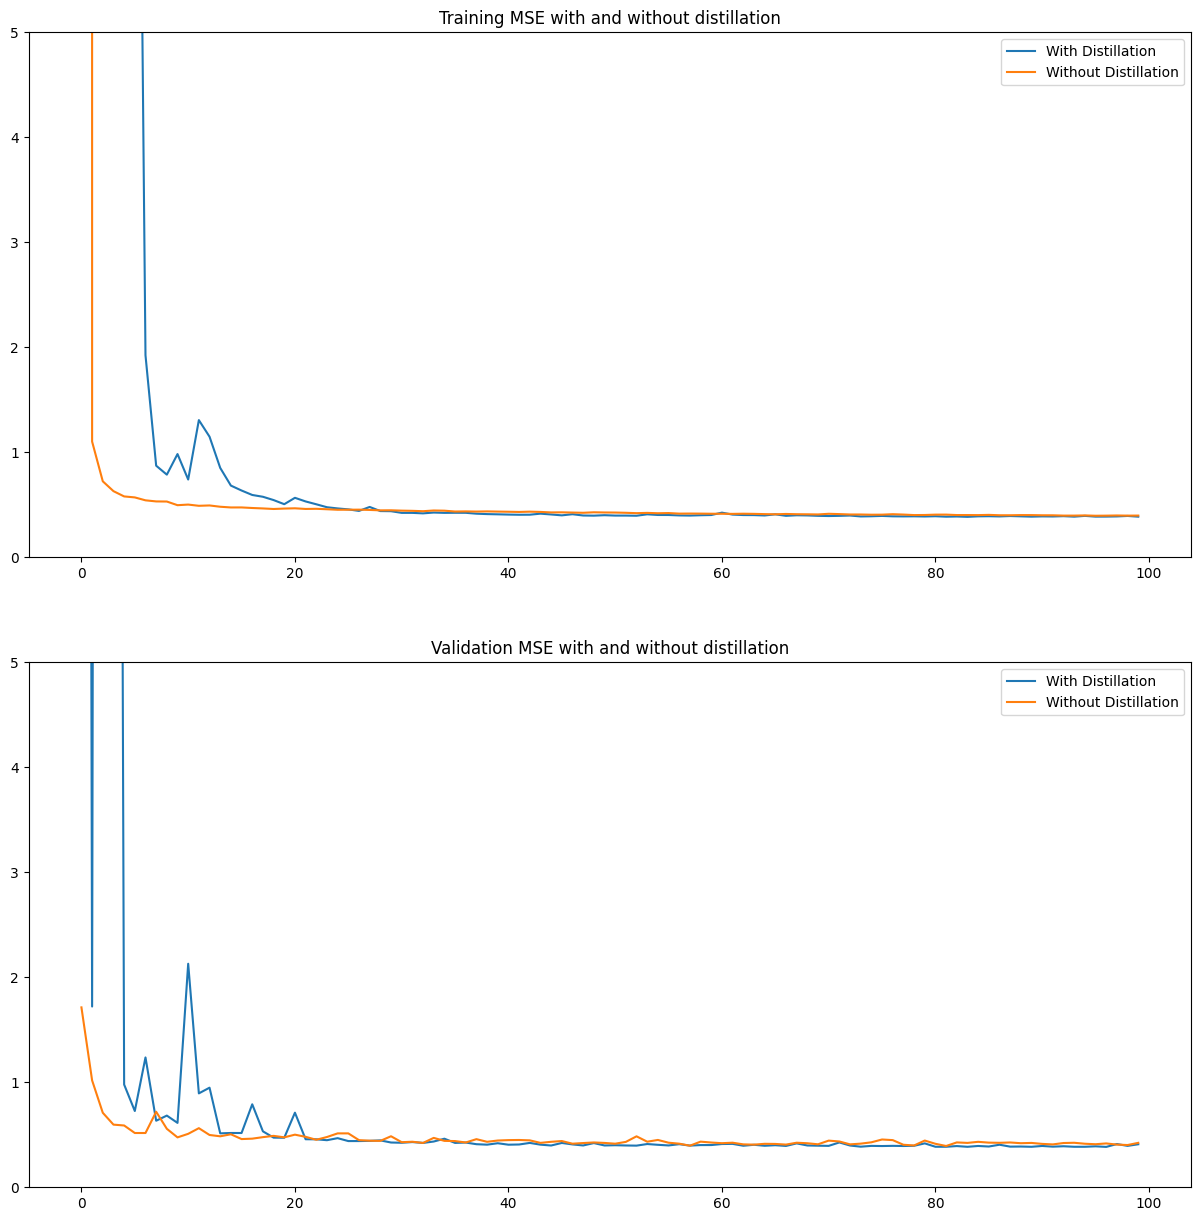

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Validation mse with distillation 0.46 +- 0.1584
Validation mse without disstillation 0.4694 +- 0.0205


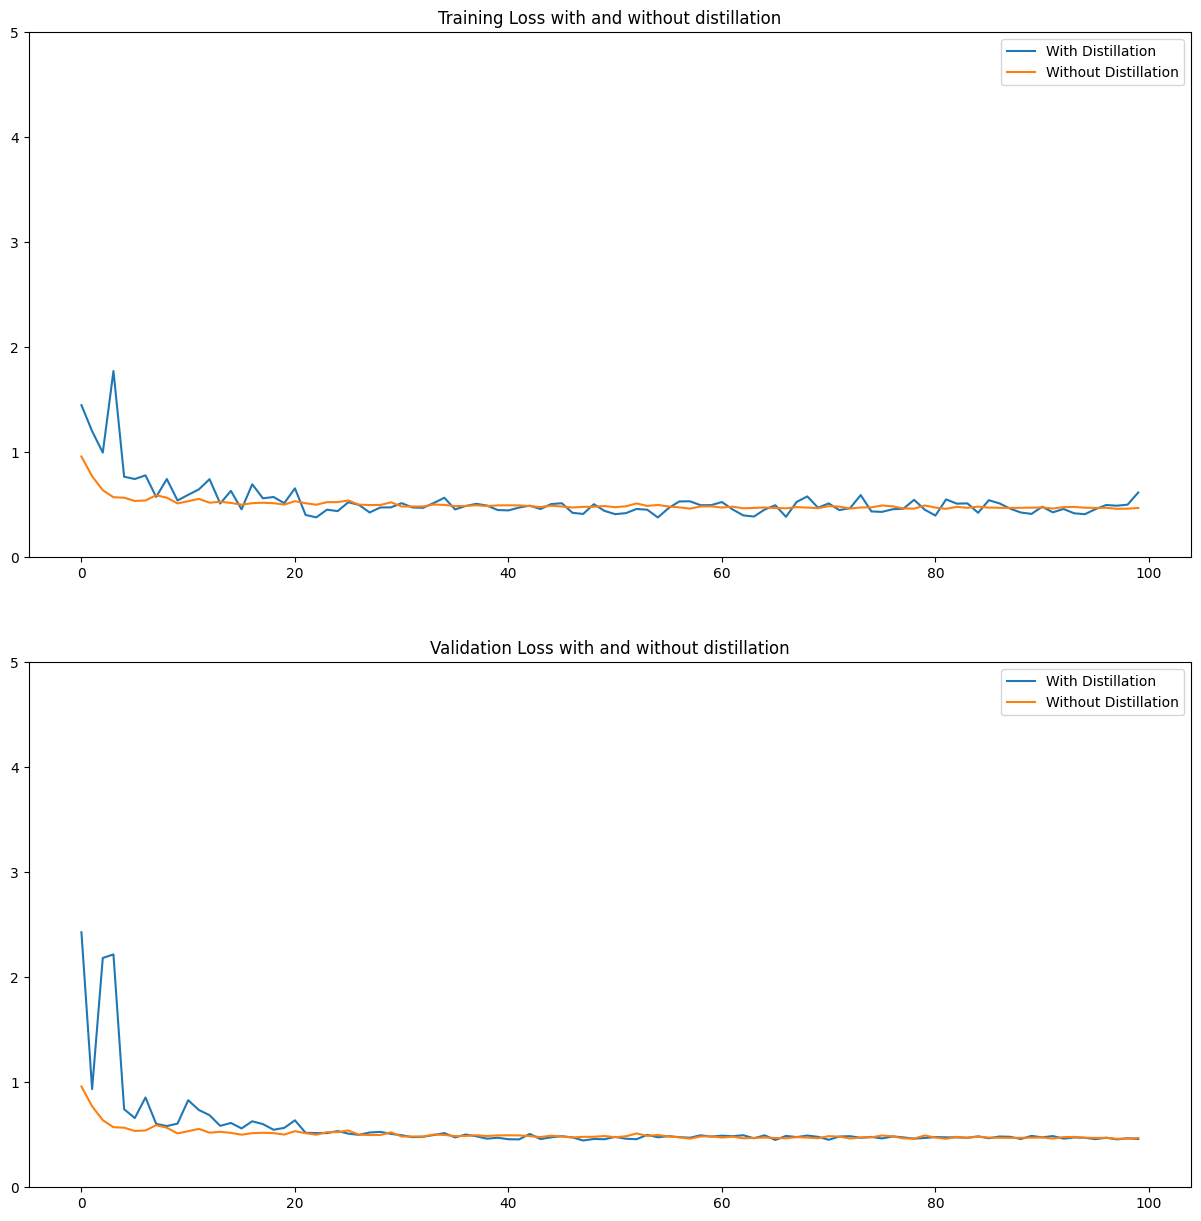

In [42]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [46]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse', 'mae', 'mape'],
    student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10        
)
# Retrain both models
distiller.fit(x_train, y_train, epochs=number_of_epochs)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=number_of_epochs)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/100
492/492 [==============================] - 2s 3ms/step - mse: 2846.5815 - mae: 9.4969 - mape: 630.9482 - student_loss: 9.4898 - distillation_loss: 2836.8556
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - mse: 15.6258 - mae: 1.5055 - mape: 100.9653 - student_loss: 1.5023 - distillation_loss: 15.1674
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - mse: 1.2265 - mae: 0.8313 - mape: 57.1155 - student_loss: 0.8342 - distillation_loss: 0.7815
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - mse: 1.6669 - mae: 0.8864 - mape: 60.6268 - student_loss: 0.8855 - distillation_loss: 1.2286
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - mse: 3.0584 - mae: 1.1634 - mape: 77.7455 - student_loss: 1.1622 - distillation_loss: 2.6015
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - mse: 1.7034 - mae: 0.8807 - mape: 58.8999 - student_loss: 0.8799 - distillation_loss: 1.2508
Epoch 7/100
492/49

492/492 [==============================] - 1s 3ms/step - mse: 0.3968 - mae: 0.4703 - mape: 30.2340 - student_loss: 0.4700 - distillation_loss: 0.0114
Epoch 52/100
492/492 [==============================] - 1s 2ms/step - mse: 0.3886 - mae: 0.4662 - mape: 29.9247 - student_loss: 0.4663 - distillation_loss: 0.0076
Epoch 53/100
492/492 [==============================] - 1s 2ms/step - mse: 0.3880 - mae: 0.4654 - mape: 29.8710 - student_loss: 0.4649 - distillation_loss: 0.0073
Epoch 54/100
492/492 [==============================] - 1s 2ms/step - mse: 0.3897 - mae: 0.4660 - mape: 29.8853 - student_loss: 0.4661 - distillation_loss: 0.0075
Epoch 55/100
492/492 [==============================] - 1s 2ms/step - mse: 0.3890 - mae: 0.4657 - mape: 29.9081 - student_loss: 0.4655 - distillation_loss: 0.0093
Epoch 56/100
492/492 [==============================] - 1s 2ms/step - mse: 0.3858 - mae: 0.4634 - mape: 29.7671 - student_loss: 0.4635 - distillation_loss: 0.0067
Epoch 57/100
492/492 [=============

492/492 [==============================] - 1s 2ms/step - loss: 8.6319 - mse: 1125.2960 - mae: 8.6319 - mape: 594.0804
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7572 - mse: 1.0274 - mae: 0.7572 - mape: 49.0043
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6272 - mse: 0.6932 - mae: 0.6272 - mape: 39.2243
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5917 - mse: 0.6355 - mae: 0.5917 - mape: 36.7467
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5566 - mse: 0.5628 - mae: 0.5566 - mape: 34.1614
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5440 - mse: 0.6041 - mae: 0.5440 - mape: 33.3713
Epoch 7/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5426 - mse: 0.5442 - mae: 0.5426 - mape: 33.1797
Epoch 8/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5359 - mse: 0.5251 - mae: 0.5359 - mape: 32.9518


492/492 [==============================] - 1s 2ms/step - loss: 0.4765 - mse: 0.4185 - mae: 0.4765 - mape: 28.9293
Epoch 66/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4725 - mse: 0.4106 - mae: 0.4725 - mape: 28.7454
Epoch 67/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4705 - mse: 0.4088 - mae: 0.4705 - mape: 28.6021
Epoch 68/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4743 - mse: 0.4136 - mae: 0.4743 - mape: 28.7662
Epoch 69/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4659 - mse: 0.4008 - mae: 0.4659 - mape: 28.2164
Epoch 70/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4660 - mse: 0.4023 - mae: 0.4660 - mape: 28.2455
Epoch 71/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4742 - mse: 0.4168 - mae: 0.4742 - mape: 28.8466
Epoch 72/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4642 - mse: 0.4020 - mae: 0.4642 - mape: 27.95

In [47]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 0.49305450916290283, 'mae': 0.5055140256881714, 'mape': 31.055343627929688, 'student_loss': 0.49882614612579346}
Test mse without disstillation {'loss': 0.4927115738391876, 'mse': 0.508552610874176, 'mae': 0.4927115738391876, 'mape': 26.326030731201172}


129/129 [==============================] - 0s 852us/step


Text(0, 0.5, 'Predicted values')

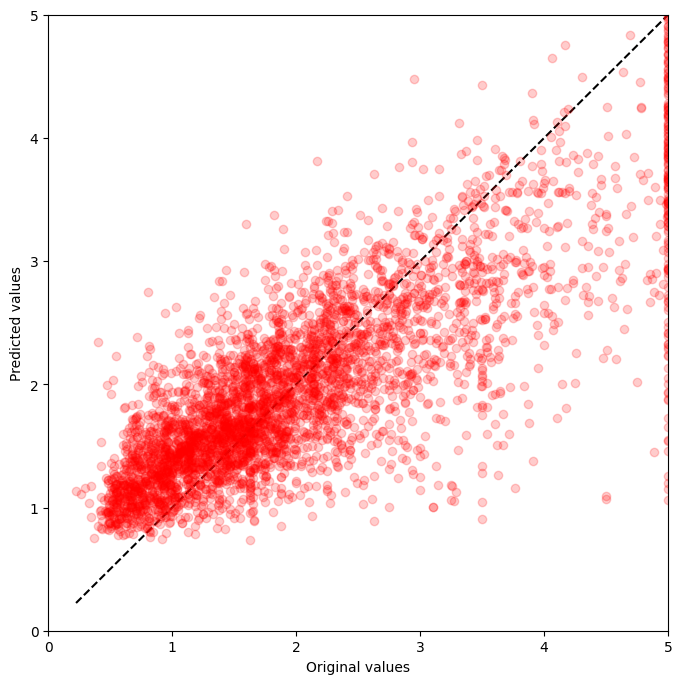

In [49]:
prediction = studnet_model.predict(x_test)

# Also plot the actual vs predicted value
plt.figure(figsize=(8,8))

ax = plt.gca()
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k--')
plt.plot(y_test, prediction, 'ro', alpha=.2)
plt.xlabel('Original values')
plt.ylabel('Predicted values')

In [22]:
# # Save the model to load in future
# %mkdir Exp1Models
#%mkdir Exp1Models/Exp2

# studnet_model.save('Exp1Models/Exp2/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp2/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets
